# 0. Intro

#### This dataset provides us information about 150 000 users in train dataset. and our task is to predict probability of default ('SeriousDlqin2yrs' column).
link:
https://www.kaggle.com/competitions/GiveMeSomeCredit/overview

#### This notebook includes:
- EDA with different visualizations.
- data preprocessing before using models.
- customers classification
- perform interpretation and analysis of classification that have been created.
- checking data drift in model monitoring section

In [2]:
# Necessary libraries import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 20,15
import seaborn as sns
sns.set_palette(palette='viridis')

# df output optimization for cases if we want to print lots of data:
pd.set_option('display.notebook_repr_html', True)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 100)

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [3]:
! pip install lightgbm -q
! pip install tqdm -q
! pip install optuna -q

# 1. EDA

In [4]:
df=pd.read_csv('cs-training.csv')
df.tail()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0
149999,150000,0,0.850283,64,0,0.249908,8158.0,8,0,2,0,0.0


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,150000.0,75000.500000,43301.414527,1.0,37500.750000,75000.500000,112500.250000,150000.0
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0


So, we can notice that there are some variables with strange distribution with extralarge max values: 
- RevolvingUtilizationOfUnsecuredLines	
- DebtRatio
- MonthlyIncome	

strange, but questionable, currently we are not sure is it normal or not:
- NumberOfTimes90DaysLate
- NumberRealEstateLoansOrLines
- NumberOfTime60-89DaysPastDueNotWorse
- NumberOfTime30-59DaysPastDueNotWorse	

In [6]:
# data types checking
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [7]:
# missing values
df.isna().sum()

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [8]:
y = df['SeriousDlqin2yrs']
X = df.drop(['SeriousDlqin2yrs', 'Unnamed: 0'], axis=1)
X.head(2)

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0


In [9]:
y.value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

# 2. Data preprocessing before using models.

#### In this dataset we have several problems that should be solved:
- outliers
- missing values
- unbalanced classes
- optional (only for regression): feature scaling

In [10]:
# feature creating (all combinations of adding, subtracting, multiplying and dividing)
def all_combinations(X):
    from itertools import combinations, combinations_with_replacement
    # add
    cc = list(combinations(X.columns, 2))
    X_add = pd.concat([X[c[1]].add(X[c[0]]) for c in cc], axis=1, keys=cc)
    X_add.columns = X_add.columns.map('_a_'.join)
    X_add.columns = ['a_' + str(col) for col in X_add.columns]
    
    # subtract
    X_sub = pd.concat([X[c[1]].sub(X[c[0]]) for c in cc], axis=1, keys=cc)
    X_sub.columns = X_sub.columns.map('_s_'.join)
    X_sub.columns = ['s_' + str(col) for col in X_sub.columns]
    
    # multiply
    cc1 = list(combinations_with_replacement(X.columns, 2))
    X_mul = pd.concat([X[c[1]].mul(X[c[0]]) for c in cc1], axis=1, keys=cc1)
    X_mul.columns = X_mul.columns.map('_m_'.join)
    X_mul.columns = ['m_' + str(col) for col in X_mul.columns]
    
    
    # divide (ratios)
    X_div = pd.concat([X[c[1]].div(X[c[0]]) for c in cc], axis=1, keys=cc)
    X_div[(X_div==np.inf) | (X_div==-np.inf)] = np.nan
    X_div.columns = X_div.columns.map('_r_'.join)
    X_div.columns = ['d_' + str(col) for col in X_div.columns]

    # joining
    X_all_combinations = X.join([X_add, X_sub, X_mul, X_div])
    if X_all_combinations.shape[0]/X_all_combinations.shape[1]<100:
        print('too much features, you need to have max ', X_all.shape[0]/100, 'features')
    return X_all_combinations

# outliers and missing values (NaNs)
def outlier(X):
    q1 = X.quantile(0.01)
    q3 = X.quantile(0.99)
    iqr = q3-q1
    lqi = q1 #- 1.5*iqr
    hqi = q3 #+ 1.5*iqr 
    X[(X > hqi)| (X < lqi) ] = np.nan #
    X.isna().sum()
    X = X.fillna(X.median())  
    return X

# feature selection
def feature_selection(X_train, y_train, X_test):
    from lightgbm import LGBMClassifier
    from sklearn.ensemble import RandomForestClassifier
    lgbm = LGBMClassifier(verbose= -1, learning_rate=0.1, max_depth=20, n_estimators=70, 
                          subsample=0.9, n_jobs=-1, randpm_state=5)
    cv = StratifiedKFold(5)
    rfecv = RFECV(estimator=lgbm, step=1, cv=cv, scoring="roc_auc", min_features_to_select=1)
    rfecv_c = rfecv.fit(X_train, y_train)
    features = X_train.columns
    mask = rfecv.get_support()
    best_features = features[mask]
    
    X_train = X_train[X_train.columns.intersection(best_features)]
    X_test = X_test[X_train.columns.intersection(best_features)]
    return X_train, X_test

# upsampling
def upsampling(X_train, y_train):
    # unbalanced classes
    df_train = pd.DataFrame(X_train, y_train).reset_index()
    rat = len(df_train.loc[df_train[y_train.name]==0])//len(df_train.loc[df_train[y_train.name]==1])

    df_1 = df_train.loc[df_train[y_train.name]==1]
    df_1 = df_1.loc[df_1.index.repeat(rat)]
    df_12 = pd.concat([df_train.loc[df_train[y_train.name]==0], df_1]).sample(frac=1)
    # so we have to reinitiate X_train and y_train
    y_train = df_12[y_train.name]
    X_train = df_12.drop([y_train.name], axis=1)
    return X_train, y_train

In [11]:
X_all = all_combinations(X)
X_all.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,a_RevolvingUtilizationOfUnsecuredLines_a_age,a_RevolvingUtilizationOfUnsecuredLines_a_NumberOfTime30-59DaysPastDueNotWorse,a_RevolvingUtilizationOfUnsecuredLines_a_DebtRatio,a_RevolvingUtilizationOfUnsecuredLines_a_MonthlyIncome,a_RevolvingUtilizationOfUnsecuredLines_a_NumberOfOpenCreditLinesAndLoans,a_RevolvingUtilizationOfUnsecuredLines_a_NumberOfTimes90DaysLate,a_RevolvingUtilizationOfUnsecuredLines_a_NumberRealEstateLoansOrLines,a_RevolvingUtilizationOfUnsecuredLines_a_NumberOfTime60-89DaysPastDueNotWorse,a_RevolvingUtilizationOfUnsecuredLines_a_NumberOfDependents,a_age_a_NumberOfTime30-59DaysPastDueNotWorse,a_age_a_DebtRatio,a_age_a_MonthlyIncome,a_age_a_NumberOfOpenCreditLinesAndLoans,a_age_a_NumberOfTimes90DaysLate,a_age_a_NumberRealEstateLoansOrLines,a_age_a_NumberOfTime60-89DaysPastDueNotWorse,a_age_a_NumberOfDependents,a_NumberOfTime30-59DaysPastDueNotWorse_a_DebtRatio,a_NumberOfTime30-59DaysPastDueNotWorse_a_MonthlyIncome,a_NumberOfTime30-59DaysPastDueNotWorse_a_NumberOfOpenCreditLinesAndLoans,a_NumberOfTime30-59DaysPastDueNotWorse_a_NumberOfTimes90DaysLate,a_NumberOfTime30-59DaysPastDueNotWorse_a_NumberRealEstateLoansOrLines,a_NumberOfTime30-59DaysPastDueNotWorse_a_NumberOfTime60-89DaysPastDueNotWorse,a_NumberOfTime30-59DaysPastDueNotWorse_a_NumberOfDependents,a_DebtRatio_a_MonthlyIncome,a_DebtRatio_a_NumberOfOpenCreditLinesAndLoans,a_DebtRatio_a_NumberOfTimes90DaysLate,a_DebtRatio_a_NumberRealEstateLoansOrLines,a_DebtRatio_a_NumberOfTime60-89DaysPastDueNotWorse,a_DebtRatio_a_NumberOfDependents,a_MonthlyIncome_a_NumberOfOpenCreditLinesAndLoans,a_MonthlyIncome_a_NumberOfTimes90DaysLate,a_MonthlyIncome_a_NumberRealEstateLoansOrLines,a_MonthlyIncome_a_NumberOfTime60-89DaysPastDueNotWorse,a_MonthlyIncome_a_NumberOfDependents,a_NumberOfOpenCreditLinesAndLoans_a_NumberOfTimes90DaysLate,a_NumberOfOpenCreditLinesAndLoans_a_NumberRealEstateLoansOrLines,a_NumberOfOpenCreditLinesAndLoans_a_NumberOfTime60-89DaysPastDueNotWorse,a_NumberOfOpenCreditLinesAndLoans_a_NumberOfDependents,a_NumberOfTimes90DaysLate_a_NumberRealEstateLoansOrLines,a_NumberOfTimes90DaysLate_a_NumberOfTime60-89DaysPastDueNotWorse,a_NumberOfTimes90DaysLate_a_NumberOfDependents,a_NumberRealEstateLoansOrLines_a_NumberOfTime60-89DaysPastDueNotWorse,a_NumberRealEstateLoansOrLines_a_NumberOfDependents,a_NumberOfTime60-89DaysPastDueNotWorse_a_NumberOfDependents,s_RevolvingUtilizationOfUnsecuredLines_s_age,s_RevolvingUtilizationOfUnsecuredLines_s_NumberOfTime30-59DaysPastDueNotWorse,s_RevolvingUtilizationOfUnsecuredLines_s_DebtRatio,s_RevolvingUtilizationOfUnsecuredLines_s_MonthlyIncome,s_RevolvingUtilizationOfUnsecuredLines_s_NumberOfOpenCreditLinesAndLoans,s_RevolvingUtilizationOfUnsecuredLines_s_NumberOfTimes90DaysLate,s_RevolvingUtilizationOfUnsecuredLines_s_NumberRealEstateLoansOrLines,s_RevolvingUtilizationOfUnsecuredLines_s_NumberOfTime60-89DaysPastDueNotWorse,s_RevolvingUtilizationOfUnsecuredLines_s_NumberOfDependents,s_age_s_NumberOfTime30-59DaysPastDueNotWorse,s_age_s_DebtRatio,s_age_s_MonthlyIncome,s_age_s_NumberOfOpenCreditLinesAndLoans,s_age_s_NumberOfTimes90DaysLate,s_age_s_NumberRealEstateLoansOrLines,s_age_s_NumberOfTime60-89DaysPastDueNotWorse,s_age_s_NumberOfDependents,s_NumberOfTime30-59DaysPastDueNotWorse_s_DebtRatio,s_NumberOfTime30-59DaysPastDueNotWorse_s_MonthlyIncome,s_NumberOfTime30-59DaysPastDueNotWorse_s_NumberOfOpenCreditLinesAndLoans,s_NumberOfTime30-59DaysPastDueNotWorse_s_NumberOfTimes90DaysLate,s_NumberOfTime30-59DaysPastDueNotWorse_s_NumberRealEstateLoansOrLines,s_NumberOfTime30-59DaysPastDueNotWorse_s_NumberOfTime60-89DaysPastDueNotWorse,s_NumberOfTime30-59DaysPastDueNotWorse_s_NumberOfDependents,s_DebtRatio_s_MonthlyIncome,s_DebtRatio_s_NumberOfOpenCreditLinesAndLoans,s_DebtRatio_s_NumberOf

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.1, stratify=y)

In [13]:
X_train = outlier(X_train)
X_test = outlier(X_test)

In [14]:
#X_train, y_train = upsampling(X_train, y_train)
# finally it was founded out that upsampling didn't improve roc_auc in current models

In [15]:
%%time
X_train, X_test = feature_selection(X_train, y_train, X_test);

CPU times: total: 2h 20min 58s
Wall time: 12min 59s


In [16]:
X_train.shape

(135000, 53)

# 3. Models

In [17]:
# tools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# boosting models
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# metrics
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, r2_score, confusion_matrix, make_scorer
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# optuna
import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.FATAL)

#### 3.1 Logistic Regression. Main advantage: interpretability

In [18]:
ss = StandardScaler()
X_train_s = pd.DataFrame(ss.fit_transform(X_train))
X_test_s = pd.DataFrame(ss.transform(X_test))
X_train_s.columns, X_test_s.columns = X_train.columns, X_test.columns

In [19]:
X_train_s.shape

(135000, 53)

In [20]:
# optuna parameters for logistic regression
def objective(trial):
    solver = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
    if solver == 'saga':
    # grid params logistic regression
        param = {
     #   'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'])
            'penalty': trial.suggest_categorical('penalty', ['none', 'l1', 'l2', 'elasticnet'])
            ,'C': trial.suggest_float('C', 1e-8, 100, log=True)
            }
    # grid params logistic regression
        lr_opt = LogisticRegression(**param, solver='saga', random_state=5, n_jobs=-1)                                   
    elif solver == 'liblinear':
        param = {
            'penalty': trial.suggest_categorical('penalty', ['l1', 'l2'])
            ,'C': trial.suggest_float('C', 1e-8, 100, log=True)}
        lr_opt = LogisticRegression(**param, solver='liblinear', random_state=5, n_jobs=-1) 
    else:
        param = {
            'solver': trial.suggest_categorical('solver', ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'])
            ,'penalty': trial.suggest_categorical('penalty', ['none', 'l2'])
            ,'C': trial.suggest_float('C', 1e-8, 100, log=True)
            }
        lr_opt = LogisticRegression(**param, random_state=5, n_jobs=-1)
                                       
#    lr_opt = LogisticRegression(**param, random_state=5, n_jobs=-1)
    lr_opt.fit(X_train, y_train)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
    scores = cross_val_score(lr_opt, X_train_s, y_train, scoring=roc_auc_scorer, cv=skf)
    return np.min([np.mean(scores), np.median([scores])])

In [21]:
%%time
# objective function calling
from optuna.pruners import SuccessiveHalvingPruner
pruner = SuccessiveHalvingPruner(min_resource=1, reduction_factor=2, min_early_stopping_rate=0)

study = optuna.create_study(direction='maximize', pruner=pruner) #, pruner=optuna.pruners.MedianPruner()
study.optimize(objective, show_progress_bar=True, timeout=3000, # n_trials=500,
              n_jobs=-1)

CPU times: total: 10min 10s
Wall time: 51min 57s


In [22]:
trial = study.best_trial
lr_opt_param = trial.params

lr_opt = LogisticRegression(**lr_opt_param, random_state=5, n_jobs=-1)
lr_opt.fit(X_train_s, y_train)
y_pred = lr_opt.predict(X_test_s)
y_pred_train = lr_opt.predict(X_train_s)

lr_opt_param

{'solver': 'newton-cholesky', 'penalty': 'none', 'C': 0.04893851892695899}

In [23]:
def evaluation_interpretation(model_type, model):
    print(roc_auc_score(y_pred_train, y_train), 'roc_auc train')
    print(roc_auc_score(y_pred, y_test), 'roc_auc test')
    print('\nclassification report outliers 0,99/0,01\n', classification_report(y_pred, y_test))
    
    plt.figure(figsize=(12,5))
    ax=sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt='g')

    labelsx=['True','False']
    labels=['True','False']
    ax.set_xticklabels(labelsx)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Ground Truth')
    
    if model_type == 'lr':
        coef = model.coef_
        intercept = model.intercept_
        coef = pd.DataFrame(coef).T
        names = pd.DataFrame(X_train_s.columns)
        f_importances = pd.concat([names, coef],axis=1)
        f_importances.columns = ['Feature', 'Coefficient']
        f_importances = f_importances.sort_values(by='Coefficient', ascending=False)
    
    else:
        from sklearn.inspection import permutation_importance
        feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
        result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
        f_importances = pd.Series(result.importances_mean, index=X_train.columns)
        f_importances = pd.DataFrame(f_importances).reset_index()
        f_importances.columns = ['Feature', 'Importance']
        f_importances['Importance'] = f_importances['Importance'] \
                                            /f_importances['Importance'].sum()
        f_importances = f_importances.sort_values(by='Importance', ascending=False)
        
    return f_importances

0.7452699752028996 roc_auc train
0.7518328337510014 roc_auc test

classification report outliers 0,99/0,01
               precision    recall  f1-score   support

           0       0.99      0.94      0.97     14787
           1       0.12      0.56      0.20       213

    accuracy                           0.93     15000
   macro avg       0.56      0.75      0.58     15000
weighted avg       0.98      0.93      0.96     15000



,Feature,Coefficient
10,a_DebtRatio_a_NumberOfTimes90DaysLate,90.149887
8,a_NumberOfTime30-59DaysPastDueNotWorse_a_DebtR...,68.841445
22,m_RevolvingUtilizationOfUnsecuredLines_m_age,0.471554
18,s_RevolvingUtilizationOfUnsecuredLines_s_Numbe...,0.185948
1,a_RevolvingUtilizationOfUnsecuredLines_a_Numbe...,0.184024
34,m_NumberOfOpenCreditLinesAndLoans_m_NumberReal...,0.182941
0,a_RevolvingUtilizationOfUnsecuredLines_a_age,0.181782
4,a_RevolvingUtilizationOfUnsecuredLines_a_Numbe...,0.181301
12,a_NumberOfTimes90DaysLate_a_NumberOfTime60-89D...,0.142337
3,a_RevolvingUtilizationOfUnsecuredLines_a_Numbe...,0.127736


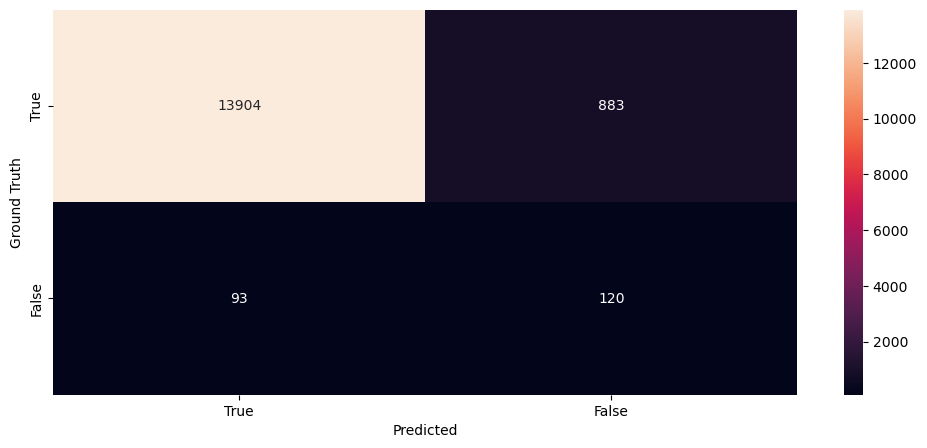

In [24]:
evaluation_interpretation('lr', lr_opt)

#### 3.2 Random forest

In [25]:
# Random forest from LightGBM due to higher speed in comparison with RandomForest from sklearn
def objective(trial):
    # grid params tree
    param = {
        'boosting_type': trial.suggest_categorical('boosting_type', ['rf'])
        ,'n_estimators': trial.suggest_int('n_estimators', 20, 2000)
        ,'max_depth': trial.suggest_int('max_depth', 2, 20)
        ,'learning_rate': trial.suggest_float('learning_rate', 1e-8, 0.1, log=True)          
        ,'subsample': trial.suggest_uniform('subsample', 0.1, 0.9)  
        ,'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1,1)
    #regularization
        ,'num_leaves': trial.suggest_int('num_leaves', 10,200)
        , 'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10, log=True)
        , 'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10, log=True)
    }
    #regularization

    lgbm_opt = LGBMClassifier(**param, n_jobs=-1, random_state=5)
    lgbm_opt.fit(X_train, y_train)
    
#    X_t, y_t = X_train.values, y_train.values
    skf = StratifiedKFold(n_splits=5, shuffle=True) #.split(X_t, y_t)
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
    scores = cross_val_score(lgbm_opt, X_train, y_train, scoring=roc_auc_scorer, cv=skf)
    return np.min([np.mean(scores), np.median([scores])])

In [26]:
%%time
# function calling
from optuna.pruners import SuccessiveHalvingPruner
pruner = SuccessiveHalvingPruner(min_resource=1, reduction_factor=2, min_early_stopping_rate=0)

study = optuna.create_study(direction='maximize', pruner=pruner) #, pruner=optuna.pruners.MedianPruner()
study.optimize(objective, show_progress_bar=True, timeout=3000, # n_trials=500,
              n_jobs=-1)

CPU times: total: 11h 25s
Wall time: 58min 38s


In [27]:
trial = study.best_trial
rf_opt_param = trial.params
rf_opt = LGBMClassifier(**rf_opt_param, n_jobs=-1, random_state=5, verbose= -1)
rf_opt.fit(X_train, y_train)
y_pred = rf_opt.predict(X_test)
y_pred_train = rf_opt.predict(X_train)

rf_opt_param

{'boosting_type': 'rf',
 'n_estimators': 1998,
 'max_depth': 14,
 'learning_rate': 0.02348116342317728,
 'subsample': 0.35614583659439625,
 'feature_fraction': 0.42170245624592906,
 'num_leaves': 200,
 'lambda_l1': 1.165956999563205e-05,
 'lambda_l2': 0.835966921760175}

0.7161697702837643 roc_auc train
0.6921926957469202 roc_auc test

classification report outliers 0,99/0,01
               precision    recall  f1-score   support

           0       0.95      0.96      0.96     13906
           1       0.46      0.42      0.44      1094

    accuracy                           0.92     15000
   macro avg       0.71      0.69      0.70     15000
weighted avg       0.92      0.92      0.92     15000



,Feature,Importance
3,a_RevolvingUtilizationOfUnsecuredLines_a_Numbe...,0.328399
31,m_DebtRatio_m_NumberOfTimes90DaysLate,0.213355
16,s_RevolvingUtilizationOfUnsecuredLines_s_Numbe...,0.195334
12,a_NumberOfTimes90DaysLate_a_NumberOfTime60-89D...,0.108769
4,a_RevolvingUtilizationOfUnsecuredLines_a_Numbe...,0.089944
18,s_RevolvingUtilizationOfUnsecuredLines_s_Numbe...,0.046500
1,a_RevolvingUtilizationOfUnsecuredLines_a_Numbe...,0.031054
47,d_DebtRatio_r_NumberOfTimes90DaysLate,0.025905
10,a_DebtRatio_a_NumberOfTimes90DaysLate,0.011907
14,s_RevolvingUtilizationOfUnsecuredLines_s_Numbe...,0.011263


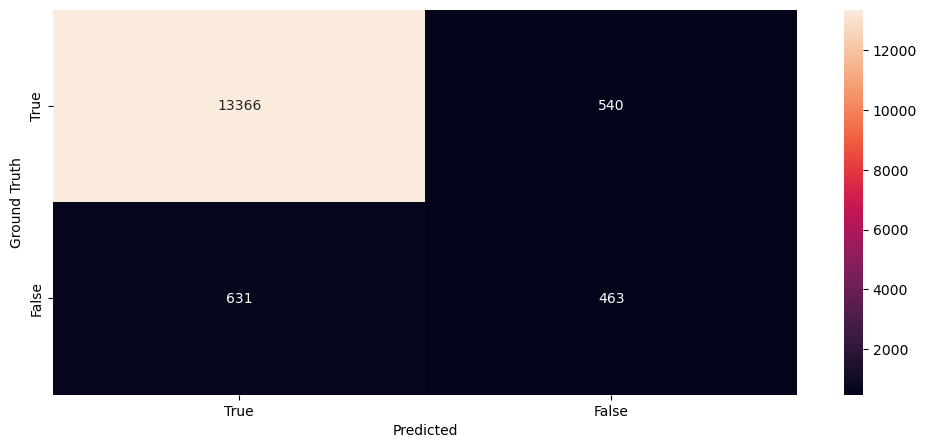

In [28]:
evaluation_interpretation('rf', rf_opt)

In [66]:
print(roc_auc_score(y_pred_train, y_train), ' train outliers boundaries 0,99/0,01')
print(roc_auc_score(y_pred, y_test), 'test outliers boundaries 0,99/0,01')
print(classification_report(y_pred, y_test), 'outliers boundaries 0,99/0,01')

0.7004642771219115  train outliers boundaries 0,99/0,01
0.6846140378757664 test outliers boundaries 0,99/0,01
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     27718
           1       0.46      0.41      0.43      2282

    accuracy                           0.92     30000
   macro avg       0.71      0.68      0.70     30000
weighted avg       0.91      0.92      0.92     30000
 outliers boundaries 0,99/0,01


In [67]:
from sklearn.inspection import permutation_importance
feature_names = [f"feature {i}" for i in range(X.shape[1])]
result = permutation_importance(rf_opt, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
rf_importances = pd.Series(result.importances_mean, index=X_test.columns)
rf_importances = pd.DataFrame(rf_importances).reset_index()
rf_importances.columns = ['Feature', 'Importance']
rf_importances['Importance'] = rf_importances['Importance'] \
                                            /rf_importances['Importance'].sum()
rf_importances.sort_values(by='Importance', ascending=False)

,Feature,Importance
34,a_NumberOfTimes90DaysLate_a_NumberOfTime60-89D...,0.360754
8,a_RevolvingUtilizationOfUnsecuredLines_a_Numbe...,0.344706
137,d_NumberOfTimes90DaysLate_r_NumberOfTime60-89D...,0.291278
41,s_RevolvingUtilizationOfUnsecuredLines_s_Numbe...,0.186574
21,a_NumberOfTime30-59DaysPastDueNotWorse_a_Numbe...,0.059626
101,d_RevolvingUtilizationOfUnsecuredLines_r_age,0.027203
108,d_RevolvingUtilizationOfUnsecuredLines_r_Numbe...,0.020158
43,s_RevolvingUtilizationOfUnsecuredLines_s_Numbe...,0.011742
89,m_DebtRatio_m_NumberOfTimes90DaysLate,0.007372
106,d_RevolvingUtilizationOfUnsecuredLines_r_Numbe...,0.006524


 #### 3.3 Boosting

In [29]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, make_scorer
def objective(trial):
    # grid params
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 2000)
        ,'max_depth': trial.suggest_int('max_depth', 2, 20)
        ,'learning_rate': trial.suggest_float('learning_rate', 1e-8, 0.1, log=True)          
        ,'subsample': trial.suggest_uniform('subsample', 0.1, 0.9)  
        ,'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1,1)
    #regularization
        ,'num_leaves': trial.suggest_int('num_leaves', 10,200)
        , 'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10, log=True)
        , 'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10, log=True)
    }
    #regularization

    lgbm_opt = LGBMClassifier(**param, verbose=-1, random_state=5, class_weight='balanced')
#    lgbm_opt.fit(X_tr, y_tr)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
    scores = cross_val_score(lgbm_opt, X_train, y_train, scoring=roc_auc_scorer, cv=skf)
    return np.min([np.mean(scores), np.median([scores])])

In [30]:
%%time
# function calling
from optuna.pruners import SuccessiveHalvingPruner, HyperbandPruner 
from optuna.integration import LightGBMPruningCallback
pruner = SuccessiveHalvingPruner(min_resource=1, reduction_factor=2, min_early_stopping_rate=0)
#pruner = LightGBMPruningCallback(trial, metric='auc')

study = optuna.create_study(direction='maximize', pruner=pruner) #, pruner=optuna.pruners.MedianPruner()
study.optimize(objective, show_progress_bar=True, timeout=3000) # n_trials=500

   0%|          | 00:00/50:00

CPU times: total: 4h 58min 22s
Wall time: 50min 3s


In [31]:
trial = study.best_trial
lgbm_opt_param = trial.params

lgbm_opt = LGBMClassifier(**lgbm_opt_param, random_state=5, verbose= -1, n_jobs=-1)
lgbm_opt.fit(X_train, y_train)
y_pred = lgbm_opt.predict(X_test)
y_pred_train = lgbm_opt.predict(X_train)

lgbm_opt_param

{'n_estimators': 589,
 'max_depth': 5,
 'learning_rate': 0.014817656530106653,
 'subsample': 0.2855827106298417,
 'feature_fraction': 0.15708028310800778,
 'num_leaves': 181,
 'lambda_l1': 9.677805259578638e-06,
 'lambda_l2': 1.0494204426331306}

In [32]:
y_pred_train.mean()

0.02057037037037037

0.8168147181193339 roc_auc train
0.7948871151996151 roc_auc test

classification report outliers 0,99/0,01
               precision    recall  f1-score   support

           0       0.99      0.94      0.97     14784
           1       0.14      0.65      0.23       216

    accuracy                           0.94     15000
   macro avg       0.57      0.79      0.60     15000
weighted avg       0.98      0.94      0.96     15000



,Feature,Importance
10,a_DebtRatio_a_NumberOfTimes90DaysLate,0.076766
1,a_RevolvingUtilizationOfUnsecuredLines_a_Numbe...,0.066530
35,d_RevolvingUtilizationOfUnsecuredLines_r_age,0.061924
24,m_RevolvingUtilizationOfUnsecuredLines_m_Numbe...,0.060901
14,s_RevolvingUtilizationOfUnsecuredLines_s_Numbe...,0.055271
16,s_RevolvingUtilizationOfUnsecuredLines_s_Numbe...,0.052201
3,a_RevolvingUtilizationOfUnsecuredLines_a_Numbe...,0.051689
31,m_DebtRatio_m_NumberOfTimes90DaysLate,0.047083
44,d_NumberOfTime30-59DaysPastDueNotWorse_r_Numbe...,0.041965
18,s_RevolvingUtilizationOfUnsecuredLines_s_Numbe...,0.041965


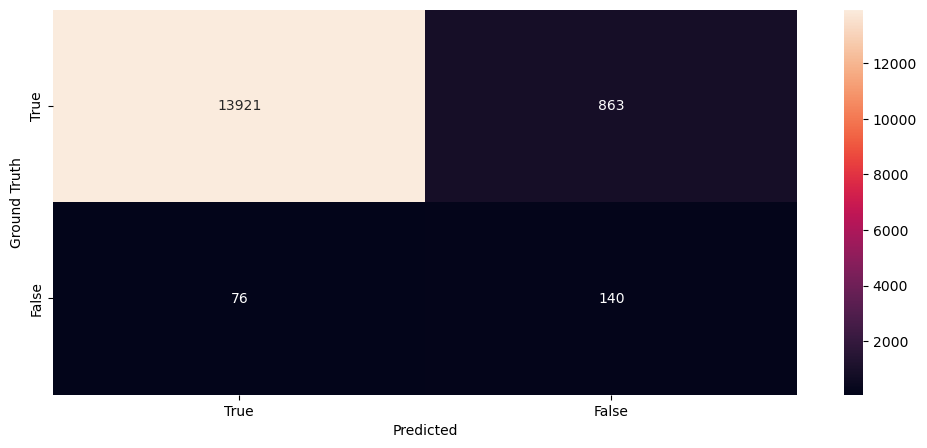

In [33]:
evaluation_interpretation('lgb', lgbm_opt)

# 5. Final predictions

In [34]:
df_test=pd.read_csv('cs-test.csv')
df_test.tail()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
101498,101499,NaN,0.282653,24,0,0.068522,1400.0,5,0,0,0,0.0
101499,101500,NaN,0.922156,36,3,0.934217,7615.0,8,0,2,0,4.0
101500,101501,NaN,0.081596,70,0,836.000000,NaN,3,0,0,0,NaN
101501,101502,NaN,0.335457,56,0,3568.000000,NaN,8,0,2,1,3.0
101502,101503,NaN,0.441842,29,0,0.198918,5916.0,12,0,0,0,0.0


In [35]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,101503.0,50752.000000,29301.536524,1.0,25376.500000,50752.000000,76127.500000,101503.0
SeriousDlqin2yrs,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RevolvingUtilizationOfUnsecuredLines,101503.0,5.310000,196.156039,0.0,0.030131,0.152586,0.564225,21821.0
age,101503.0,52.405436,14.779756,21.0,41.000000,52.000000,63.000000,104.0
NumberOfTime30-59DaysPastDueNotWorse,101503.0,0.453770,4.538487,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,101503.0,344.475020,1632.595231,0.0,0.173423,0.364260,0.851619,268326.0
MonthlyIncome,81400.0,6855.035590,36508.600375,0.0,3408.000000,5400.000000,8200.000000,7727000.0
NumberOfOpenCreditLinesAndLoans,101503.0,8.453514,5.144100,0.0,5.000000,8.000000,11.000000,85.0
NumberOfTimes90DaysLate,101503.0,0.296691,4.515859,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,101503.0,1.013074,1.110253,0.0,0.000000,1.000000,2.000000,37.0


In [36]:
df_test.isna().sum()

Unnamed: 0                                   0
SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                            20103
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                        2626
dtype: int64

In [37]:
X_tt = df_test.drop(['SeriousDlqin2yrs', 'Unnamed: 0'], axis=1)

In [38]:
X_tt_all = all_combinations(X_tt)
X_tt_all

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,a_RevolvingUtilizationOfUnsecuredLines_a_age,a_RevolvingUtilizationOfUnsecuredLines_a_NumberOfTime30-59DaysPastDueNotWorse,a_RevolvingUtilizationOfUnsecuredLines_a_DebtRatio,a_RevolvingUtilizationOfUnsecuredLines_a_MonthlyIncome,a_RevolvingUtilizationOfUnsecuredLines_a_NumberOfOpenCreditLinesAndLoans,a_RevolvingUtilizationOfUnsecuredLines_a_NumberOfTimes90DaysLate,a_RevolvingUtilizationOfUnsecuredLines_a_NumberRealEstateLoansOrLines,a_RevolvingUtilizationOfUnsecuredLines_a_NumberOfTime60-89DaysPastDueNotWorse,a_RevolvingUtilizationOfUnsecuredLines_a_NumberOfDependents,a_age_a_NumberOfTime30-59DaysPastDueNotWorse,a_age_a_DebtRatio,a_age_a_MonthlyIncome,a_age_a_NumberOfOpenCreditLinesAndLoans,a_age_a_NumberOfTimes90DaysLate,a_age_a_NumberRealEstateLoansOrLines,a_age_a_NumberOfTime60-89DaysPastDueNotWorse,a_age_a_NumberOfDependents,a_NumberOfTime30-59DaysPastDueNotWorse_a_DebtRatio,a_NumberOfTime30-59DaysPastDueNotWorse_a_MonthlyIncome,a_NumberOfTime30-59DaysPastDueNotWorse_a_NumberOfOpenCreditLinesAndLoans,a_NumberOfTime30-59DaysPastDueNotWorse_a_NumberOfTimes90DaysLate,a_NumberOfTime30-59DaysPastDueNotWorse_a_NumberRealEstateLoansOrLines,a_NumberOfTime30-59DaysPastDueNotWorse_a_NumberOfTime60-89DaysPastDueNotWorse,a_NumberOfTime30-59DaysPastDueNotWorse_a_NumberOfDependents,a_DebtRatio_a_MonthlyIncome,a_DebtRatio_a_NumberOfOpenCreditLinesAndLoans,a_DebtRatio_a_NumberOfTimes90DaysLate,a_DebtRatio_a_NumberRealEstateLoansOrLines,a_DebtRatio_a_NumberOfTime60-89DaysPastDueNotWorse,a_DebtRatio_a_NumberOfDependents,a_MonthlyIncome_a_NumberOfOpenCreditLinesAndLoans,a_MonthlyIncome_a_NumberOfTimes90DaysLate,a_MonthlyIncome_a_NumberRealEstateLoansOrLines,a_MonthlyIncome_a_NumberOfTime60-89DaysPastDueNotWorse,a_MonthlyIncome_a_NumberOfDependents,a_NumberOfOpenCreditLinesAndLoans_a_NumberOfTimes90DaysLate,a_NumberOfOpenCreditLinesAndLoans_a_NumberRealEstateLoansOrLines,a_NumberOfOpenCreditLinesAndLoans_a_NumberOfTime60-89DaysPastDueNotWorse,a_NumberOfOpenCreditLinesAndLoans_a_NumberOfDependents,a_NumberOfTimes90DaysLate_a_NumberRealEstateLoansOrLines,a_NumberOfTimes90DaysLate_a_NumberOfTime60-89DaysPastDueNotWorse,a_NumberOfTimes90DaysLate_a_NumberOfDependents,a_NumberRealEstateLoansOrLines_a_NumberOfTime60-89DaysPastDueNotWorse,a_NumberRealEstateLoansOrLines_a_NumberOfDependents,a_NumberOfTime60-89DaysPastDueNotWorse_a_NumberOfDependents,s_RevolvingUtilizationOfUnsecuredLines_s_age,s_RevolvingUtilizationOfUnsecuredLines_s_NumberOfTime30-59DaysPastDueNotWorse,s_RevolvingUtilizationOfUnsecuredLines_s_DebtRatio,s_RevolvingUtilizationOfUnsecuredLines_s_MonthlyIncome,s_RevolvingUtilizationOfUnsecuredLines_s_NumberOfOpenCreditLinesAndLoans,s_RevolvingUtilizationOfUnsecuredLines_s_NumberOfTimes90DaysLate,s_RevolvingUtilizationOfUnsecuredLines_s_NumberRealEstateLoansOrLines,s_RevolvingUtilizationOfUnsecuredLines_s_NumberOfTime60-89DaysPastDueNotWorse,s_RevolvingUtilizationOfUnsecuredLines_s_NumberOfDependents,s_age_s_NumberOfTime30-59DaysPastDueNotWorse,s_age_s_DebtRatio,s_age_s_MonthlyIncome,s_age_s_NumberOfOpenCreditLinesAndLoans,s_age_s_NumberOfTimes90DaysLate,s_age_s_NumberRealEstateLoansOrLines,s_age_s_NumberOfTime60-89DaysPastDueNotWorse,s_age_s_NumberOfDependents,s_NumberOfTime30-59DaysPastDueNotWorse_s_DebtRatio,s_NumberOfTime30-59DaysPastDueNotWorse_s_MonthlyIncome,s_NumberOfTime30-59DaysPastDueNotWorse_s_NumberOfOpenCreditLinesAndLoans,s_NumberOfTime30-59DaysPastDueNotWorse_s_NumberOfTimes90DaysLate,s_NumberOfTime30-59DaysPastDueNotWorse_s_NumberRealEstateLoansOrLines,s_NumberOfTime30-59DaysPastDueNotWorse_s_NumberOfTime60-89DaysPastDueNotWorse,s_NumberOfTime30-59DaysPastDueNotWorse_s_NumberOfDependents,s_DebtRatio_s_MonthlyIncome,s_DebtRatio_s_NumberOfOpenCreditLinesAndLoans,s_DebtRatio_s_NumberOf

In [39]:
X_tt = X_tt_all[X_tt_all.columns.intersection(X_train.columns)]
X_tt.shape

(101503, 53)

In [40]:
# missing values (NaNs)
X_tt = X_tt.fillna(X_tt.median())
X_tt_s = ss.transform(X_tt)

In [41]:
X_tt.describe().T

,count,mean,std,min,25%,50%,75%,max
a_RevolvingUtilizationOfUnsecuredLines_a_age,101503.0,5.771544e+01,1.966055e+02,2.100000e+01,42.000000,52.153620,63.027743,2.188100e+04
a_RevolvingUtilizationOfUnsecuredLines_a_NumberOfTime30-59DaysPastDueNotWorse,101503.0,5.763770e+00,1.962059e+02,0.000000e+00,0.035143,0.203898,0.911501,2.182100e+04
a_RevolvingUtilizationOfUnsecuredLines_a_DebtRatio,101503.0,3.497850e+02,1.645085e+03,0.000000e+00,0.342442,0.796021,1.515868,2.683260e+05
a_RevolvingUtilizationOfUnsecuredLines_a_NumberOfTimes90DaysLate,101503.0,5.606691e+00,1.962021e+02,0.000000e+00,0.031148,0.159996,0.610241,2.182100e+04
a_RevolvingUtilizationOfUnsecuredLines_a_NumberOfTime60-89DaysPastDueNotWorse,101503.0,5.580317e+00,1.962036e+02,0.000000e+00,0.031162,0.161017,0.616489,2.182100e+04
a_RevolvingUtilizationOfUnsecuredLines_a_NumberOfDependents,101503.0,5.978433e+00,1.949695e+02,0.000000e+00,0.077869,0.807704,1.867527,2.182100e+04
a_age_a_DebtRatio,101503.0,3.968805e+02,1.633172e+03,2.100000e+01,43.687297,56.275380,74.109228,2.683770e+05
a_age_a_NumberOfOpenCreditLinesAndLoans,101503.0,6.085895e+01,1.633300e+01,2.100000e+01,49.000000,61.000000,73.000000,1.320000e+02
a_NumberOfTime30-59DaysPastDueNotWorse_a_DebtRatio,101503.0,3.449288e+02,1.632563e+03,0.000000e+00,0.202586,0.452300,2.101922,2.683260e+05
a_DebtRatio_a_NumberOfOpenCreditLinesAndLoans,101503.0,3.529285e+02,1.632938e+03,0.000000e+00,6.131097,9.702433,17.191483,2.683380e+05


In [42]:
submission = pd.read_csv('sampleEntry.csv')

#### 5.1. Logistic Regression Submission

In [43]:
y_tt_lr = lr_opt.predict_proba(X_tt_s)[:,1]
y_tt_lr = pd.DataFrame(y_tt_lr)
#y_tt_lr
submission['Probability']=y_tt_lr
submission.to_csv('submitted_feo_lr.csv', index=False)
submission.head()

,Id,Probability
0,1,0.074828
1,2,0.049917
2,3,0.020637
3,4,0.074506
4,5,0.104695


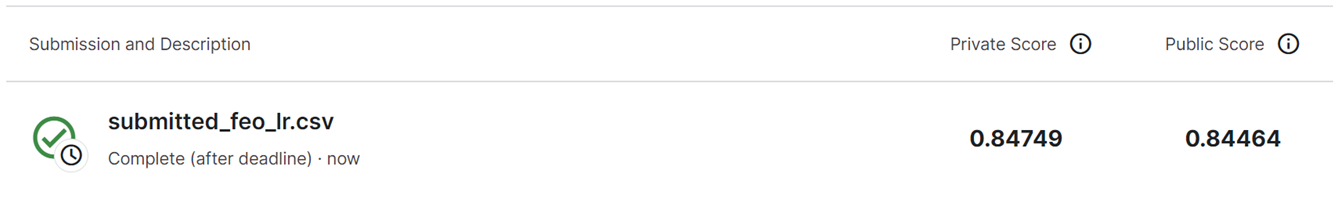

In [44]:
submission['Probability'].mean()

0.09596283351841078

#### 5.2. Random Forest Submission

In [45]:
y_tt_rf = rf_opt.predict_proba(X_tt)[:,1]
y_tt_rf = pd.DataFrame(y_tt_rf)
submission['Probability']=y_tt_rf
submission.to_csv('submitted_feo_rf.csv', index=False)
submission.head()

,Id,Probability
0,1,0.071401
1,2,0.040967
2,3,0.028885
3,4,0.087672
4,5,0.184589


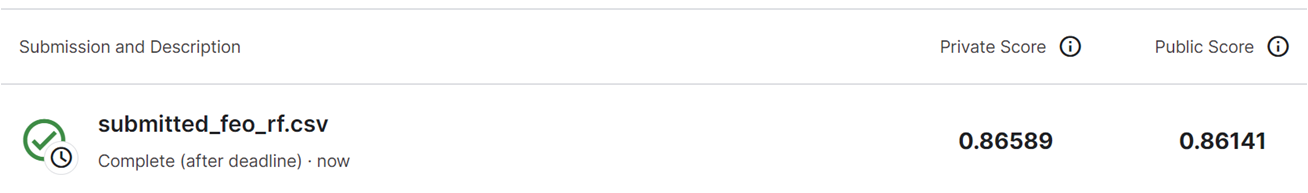

In [46]:
submission['Probability'].mean()

0.11589244414845237

#### 5.3. LightGBM Submission

In [47]:
y_tt_lgbm = lgbm_opt.predict_proba(X_tt)[:,1]
y_tt_lgbm = pd.DataFrame(y_tt_lgbm)
submission['Probability']=y_tt_lgbm
submission.to_csv('submitted_feo_lgbm.csv', index=False)
submission.head()

,Id,Probability
0,1,0.067520
1,2,0.043581
2,3,0.014737
3,4,0.085250
4,5,0.122927


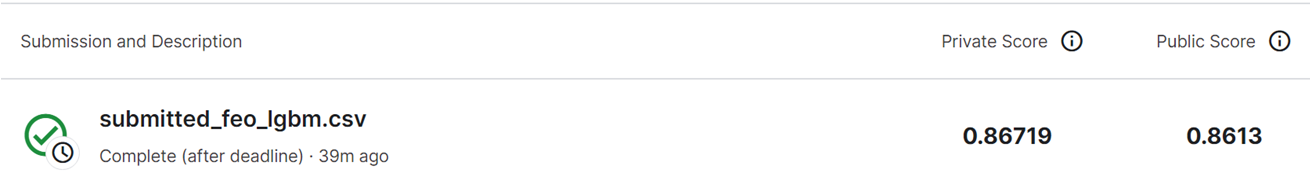

In [48]:
submission['Probability'].mean()

0.06819249263236479

# 5. Leaderboard scores

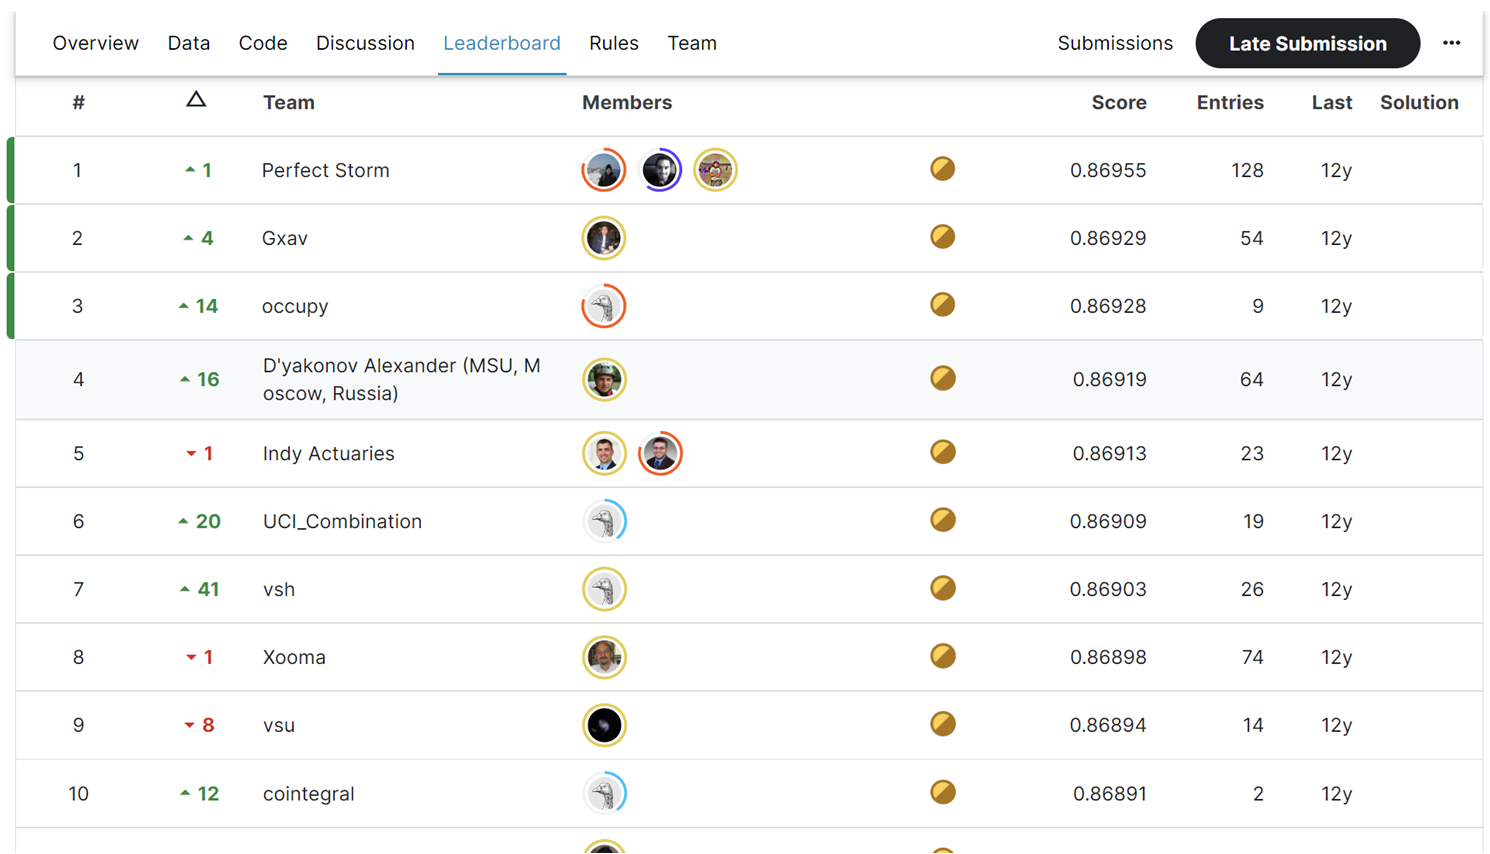

# 6. Data drift monitoring (bonus section)

In [90]:
! pip install feature_engine -q

In [141]:
def psi_feature_monitor(X_train, X_test):
    from feature_engine.selection import DropHighPSIFeatures
    transformer = DropHighPSIFeatures()
    transformer.fit(X_train, X_test)
    psi = pd.Series(transformer.psi_values_, index=X_test.columns)

    psi = pd.DataFrame(psi).reset_index() 
    psi.columns =['Feature', 'PSI']
    return print(psi.sort_values(by='PSI', ascending=False)), print('Total PSI (all features)', '\n', psi['PSI'].sum())

def psi_target_monitor(y_train, y_test):
    transformer = DropHighPSIFeatures()
    transformer.fit(y_train_lgbm, y_tt_lgbm)
    psi = pd.Series(transformer.psi_values_)
    return psi

In [143]:
psi_target_monitor(y_train, y_test)

0    0.000341
dtype: float64

In [140]:
psi_feature_monitor(X_train, X_tt)

                                               Feature           PSI
53   s_NumberOfTime30-59DaysPastDueNotWorse_s_Numbe...  9.599199e-04
31   a_NumberOfOpenCreditLinesAndLoans_a_NumberOfTi...  8.115066e-04
20   a_NumberOfTime30-59DaysPastDueNotWorse_a_Numbe...  7.978507e-04
30   a_NumberOfOpenCreditLinesAndLoans_a_NumberOfTi...  7.558219e-04
0                 RevolvingUtilizationOfUnsecuredLines  7.403672e-04
7    a_RevolvingUtilizationOfUnsecuredLines_a_Numbe...  6.707158e-04
42   s_RevolvingUtilizationOfUnsecuredLines_s_Numbe...  6.529734e-04
40   s_RevolvingUtilizationOfUnsecuredLines_s_Numbe...  6.124958e-04
25       a_DebtRatio_a_NumberOfOpenCreditLinesAndLoans  6.049208e-04
32   a_NumberOfOpenCreditLinesAndLoans_a_NumberOfDe...  5.699813e-04
101       d_RevolvingUtilizationOfUnsecuredLines_r_age  5.554370e-04
56       s_DebtRatio_s_NumberOfOpenCreditLinesAndLoans  5.522650e-04
8    a_RevolvingUtilizationOfUnsecuredLines_a_Numbe...  5.359397e-04
10   a_RevolvingUtilizationOfUnsec

(None, None)

#### As a conclusion we can notice that train/test samples and new sapmle for prediction have only minor changes and suits for ML models perfectly.
#### It was confirmed by high scores onkaggle submission page.